In [1]:
import torch

In [33]:
torch.__version__

'1.13.0'

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import shutil
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.cuda.comm
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from models.ST_Former import GenerateModel
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dataloader.dataset_NIA import train_data_loader, test_data_loader
import wandb

In [3]:
from runner_helper import *

In [4]:
class Pseudoarg():
    def __init__(self):
        self.workers = 1
        self.epochs = 200
        self.start_epoch = 0
        self.batch_size = 16
        self.lr = 0.001
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.print_freq = 10
        self.resume = None
        self.data_set = 0
        
args = Pseudoarg()

In [5]:
model = GenerateModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.nn.DataParallel(model).cuda()

In [6]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
else:
    print("Can't use CUDA")
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3090
__CUDA Device Total Memory [GB]: 25.438322688


In [7]:
now = datetime.datetime.now()
time_str = now.strftime("[%m-%d]-[%H:%M]-")
project_path = '/media/di/data/lee/nia/Former-DFER/nia/data/'
log_txt_path = project_path + 'log/' + time_str + 'set' + str(args.data_set) + '-log.txt'
log_curve_path = project_path + 'log/' + time_str + 'set' + str(args.data_set) + '-log.png'
checkpoint_path = project_path + 'checkpoint/' + time_str + 'set' + str(args.data_set) + '-model.pth'
best_checkpoint_path = project_path + 'checkpoint/' + time_str + 'set' + str(args.data_set) + '-model_best.pth'


In [35]:
pwd

'/media/di/data/500G_backup/nia/Former-DFER'

In [36]:
log_txt_path

'/media/di/data/lee/nia/Former-DFER/nia/data/log/[11-10]-[09:56]-set0-log.txt'

In [8]:
#def main():
best_acc = 0
recorder = RecorderMeter(args.epochs)
print('The training time: ' + now.strftime("%m-%d %H:%M"))
print('The training set: set ' + str(args.data_set))
os.makedirs("/media/di/data/lee/nia/Former-DFER/nia/data/log",exist_ok = True)
with open(log_txt_path, 'a') as f:
    f.write('The training set: set ' + str(args.data_set) + '\n')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# create model and load pre_trained parameters

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), args.lr, 
                             # momentum=args.momentum, 
                             weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)


The training time: 12-19 15:52
The training set: set 0
Using cuda device


In [9]:
def train(train_loader, model, criterion, optimizer, epoch, args):
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Accuracy', ':6.3f')
    progress = ProgressMeter(len(train_loader),
                             [losses, top1],
                             prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    for i, (images, target) in enumerate(train_loader):

        images = images.cuda()
        target = target.cuda()

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, _ = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print loss and accuracy
        if i % args.print_freq == 0:
            progress.display(i, log_txt_path)

    return top1.avg, losses.avg


def validate(val_loader, model, criterion, args):
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Accuracy', ':6.3f')
    progress = ProgressMeter(len(val_loader),
                             [losses, top1],
                             prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda()
            target = target.cuda()

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, _ = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))

            if i % args.print_freq == 0:
                progress.display(i, log_txt_path)

        # TODO: this should also be done with the ProgressMeter
        print('Current Accuracy: {top1.avg:.3f}'.format(top1=top1))
        with open(log_txt_path, 'a') as f:
            f.write('Current Accuracy: {top1.avg:.3f}'.format(top1=top1) + '\n')
    return top1.avg, losses.avg


def save_checkpoint(state, is_best):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_checkpoint_path)

In [10]:
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        recorder = checkpoint['recorder']
        best_acc = best_acc.cuda()
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))
cudnn.benchmark = True

In [11]:
train_data.num_segments

NameError: name 'train_data' is not defined

In [12]:
# Data loading code
train_data = train_data_loader(project_dir=project_path, 
                               data_set=args.data_set)
test_data = test_data_loader(project_dir=project_path,
                             data_set=args.data_set)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True,
                                           drop_last=True)
val_loader = torch.utils.data.DataLoader(test_data,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.workers,
                                         pin_memory=True)

video number:2801
video number:800


In [43]:
len(train_data.video_list)

2801

In [15]:
start_time = datetime.datetime.now()
print('start :',start_time)

wandb.init(project='nia')
for epoch in range(args.start_epoch, args.epochs):
    inf = '********************' + str(epoch) + '********************'
    start_time = time.time()
    current_learning_rate = optimizer.state_dict()['param_groups'][0]['lr']

    with open(log_txt_path, 'a') as f:
        f.write(inf + '\n')
        f.write('Current learning rate: ' + str(current_learning_rate) + '\n')

    print(inf)
    print('Current learning rate: ', current_learning_rate)

    # train for one epoch
    train_acc, train_los = train(train_loader, model, criterion, optimizer, epoch, args)

    # evaluate on validation set
    val_acc, val_los = validate(val_loader, model, criterion, args)

    scheduler.step()

    # remember best acc and save checkpoint
    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    save_checkpoint({'epoch': epoch + 1,
                     'state_dict': model.state_dict(),
                     'best_acc': best_acc,
                     'optimizer': optimizer.state_dict(),
                     'recorder': recorder}, is_best)

    # print and save log
    epoch_time = time.time() - start_time
    recorder.update(epoch, train_los, train_acc, val_los, val_acc)
    recorder.plot_curve(log_curve_path)
    
    wandb.log({"Train_Loss" : train_los, "Accuracy": train_acc}, step = epoch)
    print('The best accuracy: {:.3f}'.format(best_acc.item()))
    print('An epoch time: {:.1f}s'.format(epoch_time))
    with open(log_txt_path, 'a') as f:
        f.write('The best accuracy: ' + str(best_acc.item()) + '\n')
        f.write('An epoch time: {:.1f}s' + str(epoch_time) + '\n')
    
end_time = datetime.datetime.now()
print('end :',end_time)

start : 2022-12-19 15:52:58.376715


********************0********************
Current learning rate:  0.001
Epoch: [0][  0/175]	Loss 1.6778 (1.6778)	Accuracy 25.000 (25.000)
Epoch: [0][ 10/175]	Loss 1.6440 (1.6914)	Accuracy 25.000 (19.886)
Epoch: [0][ 20/175]	Loss 1.7268 (1.7426)	Accuracy 12.500 (19.940)
Epoch: [0][ 30/175]	Loss 1.6688 (1.7823)	Accuracy 25.000 (19.758)
Epoch: [0][ 40/175]	Loss 1.6039 (1.7619)	Accuracy 12.500 (21.189)
Epoch: [0][ 50/175]	Loss 1.8541 (1.7653)	Accuracy 12.500 (19.853)
Epoch: [0][ 60/175]	Loss 2.2725 (1.7779)	Accuracy  6.250 (19.672)
Epoch: [0][ 70/175]	Loss 1.5886 (1.7767)	Accuracy 25.000 (19.894)
Epoch: [0][ 80/175]	Loss 1.5947 (1.7714)	Accuracy 25.000 (20.293)


KeyboardInterrupt: 

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [94]:
start_time
end_time

datetime.datetime(2022, 11, 7, 20, 38, 53, 972860)

In [3]:
import matplotlib.pyplot as plt 
import numpy as np

In [11]:
xmi = 830.098   
ymi = 356.852  
xma = 1096.779  
yma = 721.920

In [4]:
pts = np.array([912.174,  503.501,  1028.599,  499.860,  979.652,  566.535,  929.469,  636.210,  1021.898,  632.940]).reshape(5,2)

In [5]:
pts

array([[ 912.174,  503.501],
       [1028.599,  499.86 ],
       [ 979.652,  566.535],
       [ 929.469,  636.21 ],
       [1021.898,  632.94 ]])

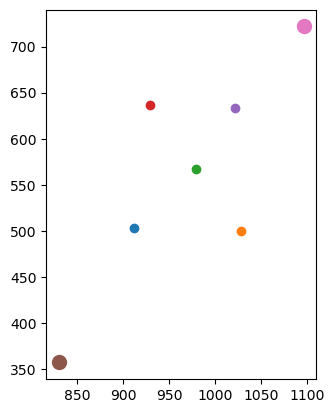

In [13]:
fig, ax  =plt.subplots()
for (x,y) in pts:
    ax.scatter(x,y)
    
ax.scatter(xmi,ymi, s=100)
ax.scatter(xma,yma, s=100)
ax.set_aspect("equal")
plt.show()